Long Short Term Memory (LSTM) Networks using PyTorch

Long Short-Term Memory (LSTM) networks are a special type of Recurrent Neural Network (RNN) designed to address the vanishing gradient problem, which makes it difficult for traditional RNNs to learn long-term dependencies in sequential data.

This notebook is based on https://www.geeksforgeeks.org/deep-learning/long-short-term-memory-networks-using-pytorch/

LSTMs use memory cells controlled by three gates:

```
Input Gate: decides what new information should be stored.
Forget Gate: decides what information should be discarded.
Output Gate: decides what information to output at each step.
```

This structure allows LSTMs to remember useful information for long periods while ignoring irrelevant details. In this article, we will learn how to implement an LSTM in PyTorch for sequence prediction on synthetic sine wave data.
Long Short-Term Memory (LSTM) Networks using PyTorch

LSTMs are widely used for sequence modeling tasks because of their ability to capture long-term dependencies. PyTorch provides a clean and flexible API to build and train LSTM models. In PyTorch, the nn.LSTM module handles the recurrence logic, while the rest of the architecture (such as fully connected layers, dropout, etc.) can be customized as needed.
Key Components

1. Input Size: Number of features in the input sequence at each time step.

1. Hidden Size: Number of features in the hidden state.

1. Number of Layers: Stacking multiple LSTM layers deepens the model.

1. Batch First: If set to True, input/output tensors are provided as (batch, seq_len, features) instead of (seq_len, batch, features).

1. Outputs:

   Output Sequence: Hidden states at each time step.
   Hidden State: Final hidden state for all layers.
   Cell State: Final memory cell state for all layers.

In [19]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)
torch.manual_seed(0)

In [20]:
import csv
import os
import pandas as pd


# Load data using pandas for easier handling of mixed types
path = os.path.join("../data", "integrated_data_20251016_200417.csv")
df = pd.read_csv(path)


print("DataFrame shape:", df.shape)
print("Columns:", list(df.columns))
print("\nFirst 5 rows:")
print(df.head())

# Extract numeric columns for LSTM (skip timestamp and hand_label)
numeric_columns = ['iteration', 'env0', 'raw0', 'env1', 'raw1', 'env2', 'raw2', 'env3', 'raw3', 
                   'thumb_tip', 'thumb_base', 'index', 'middle', 'ring', 'pinky']

# Convert to numpy array
data = df[numeric_columns].values.astype(np.float32)

print(f"\nNumeric data shape: {data.shape}")
print("First 5 rows of numeric data:")
print(data[:5])

# Alternative: Load with numpy but skip header and string columns
# data = np.loadtxt(path, delimiter=',', skiprows=1, usecols=range(1, 16), dtype=np.float32)
# This would give you columns 1-15 (iteration through pinky), skipping timestamp and hand_label 

DataFrame shape: (242, 17)
Columns: ['timestamp', 'iteration', 'env0', 'raw0', 'env1', 'raw1', 'env2', 'raw2', 'env3', 'raw3', 'thumb_tip', 'thumb_base', 'index', 'middle', 'ring', 'pinky', 'hand_label']

First 5 rows:
                    timestamp  iteration  env0  raw0  env1  raw1  env2  raw2  \
0  2025-10-16T20:04:24.679556          0   617   560   355   401   680   679   
1  2025-10-16T20:04:24.799685          1   443   571   283   411   805   674   
2  2025-10-16T20:04:24.920325          2  1016   571   213   411   674   670   
3  2025-10-16T20:04:24.997649          3   475   571   468   401   837   668   
4  2025-10-16T20:04:25.179846          4   942   571   299   401   757   665   

   env3  raw3  thumb_tip  thumb_base   index  middle    ring   pinky  \
0   292   276     0.0000      0.0000  0.0000  0.0000  0.0000  0.0000   
1   253   274     0.0000      0.0000  0.0000  0.0000  0.0000  0.0000   
2   312   264     0.0000      0.0000  0.0000  0.0000  0.0000  0.0000   
3   281   26

In [ ]:


def create_sequences(data, seq_length, target_column=-1):
    """
    Create sequences from time series data.
    
    Args:
        data: numpy array of shape (samples, features)
        seq_length: length of each sequence
        target_column: which column to predict (default: last column)
    
    Returns:
        X: sequences of shape (num_sequences, seq_length, num_features)
        y: targets of shape (num_sequences, 1)
    """
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]  # Sequence of seq_length samples
        y = data[i + seq_length, target_column]  # Predict next value of target column
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)


seq_length = 10

# For now, let's predict the next thumb_tip value (column 9, 0-indexed)
# You can change target_column to predict different features
X, y = create_sequences(data, seq_length, target_column=9)  # thumb_tip is column 9

print(f"Input shape: {X.shape}")  # (num_sequences, seq_length, num_features)
print(f"Target shape: {y.shape}")  # (num_sequences, 1)

# Convert to PyTorch tensors
trainX = torch.tensor(X, dtype=torch.float32)
trainY = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)  # Add dimension for single output

print(f"TrainX shape: {trainX.shape}")
print(f"TrainY shape: {trainY.shape}")

Input shape: (232, 10, 15)
Target shape: (232,)
TrainX shape: torch.Size([232, 10, 15])
TrainY shape: torch.Size([232, 1])


```
nn.LSTM: processes sequential data.
nn.Linear: maps hidden state outputs to predictions.
forward(): runs the data through LSTM + Fully Connected layer.
```

In [22]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, h0=None, c0=None):
        if h0 is None or c0 is None:
            h0 = torch.zeros(self.layer_dim, x.size(
                0), self.hidden_dim).to(x.device)
            c0 = torch.zeros(self.layer_dim, x.size(
                0), self.hidden_dim).to(x.device)

        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Take last time step
        return out, hn, cn

In [23]:
model = LSTMModel(input_dim=15, hidden_dim=100, layer_dim=1, output_dim=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [24]:
num_epochs = 100
h0, c0 = None, None

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    outputs, h0, c0 = model(trainX, h0, c0)

    loss = criterion(outputs, trainY)
    loss.backward()
    optimizer.step()

    h0, c0 = h0.detach(), c0.detach()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 0.0196
Epoch [20/100], Loss: 0.0133
Epoch [30/100], Loss: 0.0089
Epoch [40/100], Loss: 0.0081
Epoch [50/100], Loss: 0.0073
Epoch [60/100], Loss: 0.0067
Epoch [70/100], Loss: 0.0064
Epoch [80/100], Loss: 0.0061
Epoch [50/100], Loss: 0.0073
Epoch [60/100], Loss: 0.0067
Epoch [70/100], Loss: 0.0064
Epoch [80/100], Loss: 0.0061
Epoch [90/100], Loss: 0.0059
Epoch [100/100], Loss: 0.0056
Epoch [90/100], Loss: 0.0059
Epoch [100/100], Loss: 0.0056


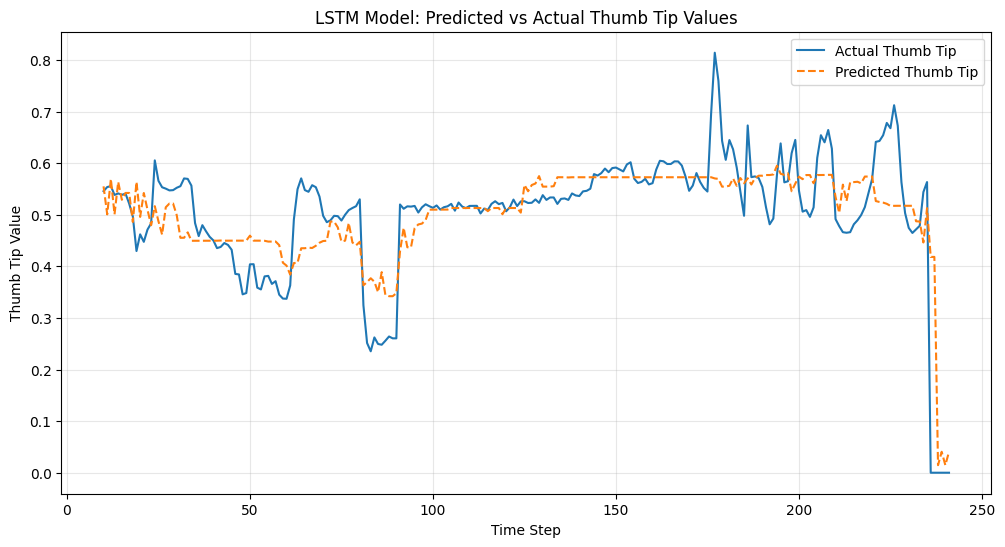

MSE: 0.0056
RMSE: 0.0749


In [ ]:
model.eval()
predicted, _, _ = model(trainX, h0, c0)

# Extract the actual thumb_tip values (column 9) for comparison
actual_thumb_tip = data[seq_length:, 9]  # Skip first seq_length samples, take thumb_tip column
time_steps = np.arange(seq_length, len(data))



plt.figure(figsize=(12, 6))
plt.plot(time_steps, actual_thumb_tip, label='Actual Thumb Tip')
plt.plot(time_steps, predicted.detach().numpy().flatten(), 
         label='Predicted Thumb Tip', linestyle='--')
plt.title('LSTM Model: Predicted vs Actual Thumb Tip Values')
plt.xlabel('Time Step')
plt.ylabel('Thumb Tip Value')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Calculate and print some metrics
mse = np.mean((predicted.detach().numpy().flatten() - actual_thumb_tip) ** 2)
rmse = np.sqrt(mse)
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")